In [1]:
from __future__ import print_function
import numpy as np
import gym
from gym import spaces
import sys
from IPython.display import clear_output
from time import sleep
import torch
class MultiWindyGridWorldEnv(gym.Env):
    '''Creates the Windy GridWorld Environment'''
    def __init__(self, GRID_HEIGHT=7, GRID_WIDTH=10,\
                 WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0], \
                 START_STATE_1 = (3, 0), START_STATE_2 = (3, 0), GOAL_STATE = (3, 7),\
                 REWARD = -0.5):
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.wind = WIND
        
        self.start_state_1 = START_STATE_1
        self.start_state_2 = START_STATE_2 #<--
        
        self.goal_state = GOAL_STATE
        self.reward = REWARD
        
        self.action_space =  spaces.Discrete(4)
        self.observation_1 = START_STATE_1
        self.observation_2 = START_STATE_2
#         self.observation_space_1 = spaces.Tuple((spaces.Discrete(self.grid_height),spaces.Discrete(self.grid_width)))
#         self.observation_space_2 = spaces.Tuple((spaces.Discrete(self.grid_height),spaces.Discrete(self.grid_width))) #<--

        self.actions = { 'U':0,   #up
                         'R':1,   #right
                         'D':2,   #down
                         'L':3,  #left
                         'N':4 } # no movement
        # set up destinations for each action in each state
        self.action_destination_1 = np.empty((self.grid_height,self.grid_width), dtype=dict) 
        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                destination[self.actions['U']] = (max(i - 1 - self.wind[j], 0), j)
                destination[self.actions['D']] = (max(min(i + 1 - self.wind[j], \
                                                    self.grid_height - 1), 0), j)
                destination[self.actions['L']] = (max(i - self.wind[j], 0),\
                                                       max(j - 1, 0))
                destination[self.actions['R']] = (max(i - self.wind[j], 0),\
                                                   min(j + 1, self.grid_width - 1))
                destination[self.actions['N']] = (i,j)
                self.action_destination_1[i,j]=destination
        
        self.action_destination_2 = np.empty((self.grid_height,self.grid_width), dtype=dict) #<--
        for i in range(0, self.grid_height):
            for j in range(0, self.grid_width):
                destination = dict()
                destination[self.actions['U']] = (max(i - 1 - self.wind[j], 0), j)
                destination[self.actions['D']] = (max(min(i + 1 - self.wind[j], \
                                                    self.grid_height - 1), 0), j)
                destination[self.actions['L']] = (max(i - self.wind[j], 0),\
                                                       max(j - 1, 0))
                destination[self.actions['R']] = (max(i - self.wind[j], 0),\
                                                   min(j + 1, self.grid_width - 1))
                destination[self.actions['N']] = (i,j)
                
                self.action_destination_2[i,j]=destination       
    
        self.nA = len(self.actions)        
    
    def step(self, action1,action2 ):
        reward = -1

        #assert self.action_space.contains(action1,action2)
        self.observation_1 = self.action_destination_1[self.observation_1][action1]
        self.observation_2 = self.action_destination_2[self.observation_2][action2]
        done1 = False
        done2 = False
        if self.observation_1 == self.goal_state:
            done1 = True
        if self.observation_2 == self.goal_state:
            done2 = True
        
        if done2 == True or done1 == True:
            reward = -0.5
        
        if done2 == True and done1 == True:
            reward =  10

        elif self.sqr_dist(self.observation_1, self.observation_2)==0: #or self.sqr_dist(self.observation_1, self.observation_2)>3:
            reward = -10
            
        #done = done1 and done2
        return self.observation_1, self.observation_2, reward, done1, done2
        
    def reset(self):
        ''' resets the agent position back to the starting position'''
        self.observation_1 = self.start_state_1
        self.observation_2 = self.start_state_2
        return self.observation_1, self.observation_2
    
    def sqr_dist(self, pos1, pos2):
        return (pos1[0]-pos2[0])*(pos1[0]-pos2[0])+(pos1[1]-pos2[1])*(pos1[1]-pos2[1])
    
    def render(self, mode='human', close=False):

        outfile = sys.stdout
        nS = self.grid_height * self.grid_width
        shape = (self.grid_height, self. grid_width)

        outboard = ""
        for y in range(-1, self.grid_height + 1):
            outline = ""
            for x in range(-1, self.grid_width + 1):
                position = (y, x)
                if self.observation_1 == position:
                    output = "A"
                elif self.observation_2 == position:
                    output = "B"
                elif position == self.goal_state:
                    output = "G"
#                 elif position == self.start_state_1:
#                     output = "S1"
#                 elif position == self.start_state_2:
#                     output = "S2"
                elif x in {-1, self.grid_width } or y in {-1, self.grid_height}:
                    output = "#"
                else:
                    output = " "

                if position[1] == shape[1]:
                    output += '\n'
                outline += output
            outboard += outline
        outboard += '\n'
        outfile.write(outboard)

    def seed(self, seed=None):
        pass

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Friend-or-Feo

In [ ]:
class FOF_agent:
    def __init__(self, numStates1, numStates2, numActionsA=5, numActionsB=5, decay=0.999, eps=1, gamma=1):
        
        self.decay = decay
        self.eps = eps
        self. stationary_eps = eps
        self.gamma = gamma
        self.alpha = 0.8
        self.V = np.ones([numStates1,numStates2])
        self.Q = np.zeros((numStates1,numStates2, numActionsA, numActionsB))
        self.numActionsA = numActionsA
        self.numActionsB = numActionsB
            
    def chooseAction(self, state, agent, doneA,doneB):
        if agent == 'A' and doneB and not doneA:
            action = self.select(state, agent, self.stationary_eps)
            return action
        
        elif agent == 'B' and doneA and not doneB:
            action = self.select(state, agent, self.stationary_eps)
            return action
        else:
            action = self.select(state, agent, self.eps)
            return action

    def updateQ(self, s, s_prime, actions, reward):

        actionA, actionB = actions
        s1 = s[0]
        s2 = s[1]
        ns1 = s_prime[0]
        ns2 = s_prime[1]
        
        self.Q[s1, s2, actionA, actionB] = (1 - self.alpha) * self.Q[s1, s2, actionA, actionB] + \
            self.alpha * (reward + self.gamma * self.V[ns1,ns2])
        
        self.V[s1,s2] = np.max(self.Q[s1,s2])
        
        
    def select(self, state, agent, eps):
        if np.random.rand() < eps:
            action = np.random.randint(4)
            return action
        else:
            s1 = state[0]
            s2 = state[1]
            if agent == 'A':
                return np.unravel_index(np.argmax(self.Q[s1,s2]), self.Q[s1,s2].shape)[0]
            if agent == 'B':
                return np.unravel_index(np.argmax(self.Q[s1,s2]), self.Q[s1,s2].shape)[1]   
   

In [ ]:
env = MultiWindyGridWorldEnv()
AgentA = FOF_agent(numStates1 = 7, numStates2 = 10)
AgentB = FOF_agent(numStates1 = 7, numStates2 = 10)

n_episodes = 200
Reward_FOF = []
for i_episode in range(1, n_episodes+1):

    stateA, stateB = env.reset()
    stateA = np.array(stateA)
    stateB = np.array(stateB)
    done = False
    done1, done2 = False, False
    R = 0
    while not done:
        if not done1:
            actionA = AgentA.chooseAction(stateA, 'A', done1, done2)
        elif done1: 
            actionA = 4

        if not done2:
            actionB = AgentB.chooseAction(stateB, 'B', done1, done2)
        elif done2: 
            actionB = 4

        next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)

        next_stateA = np.array(next_stateA)
        next_stateB = np.array(next_stateB)
        
        
        if actionB != 4:
            AgentB.updateQ(stateB, next_stateB, [np.random.randint(4), actionB], reward)
        if actionA != 4: 
            AgentA.updateQ(stateA, next_stateA, [actionA, np.random.randint(4)], reward)
            
        stateA = next_stateA
        stateB = next_stateB
        
        done = done1 and done2
        R += reward
    Reward_FOF.append(R)
    if AgentA.eps > 0.05:
            AgentA.eps *= 0.995
    if AgentB.eps > 0.05:
            AgentB.eps *= 0.995 
            
    if AgentA.stationary_eps > 0.05:
            AgentA.stationary_eps *= 0.995
    if AgentB.stationary_eps > 0.05:
            AgentB.stationary_eps *= 0.995

    AgentA.alpha *= AgentA.decay
    AgentB.alpha *= AgentB.decay

    if i_episode%100 == 0:
      print(i_episode)

100
200


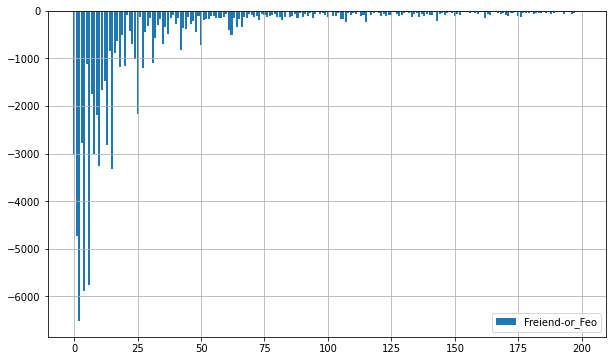

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.bar(np.arange(len(Reward_FOF)), Reward_FOF, label ='Freiend-or_Feo')
ax.grid()
ax.legend()


In [ ]:
stateA, stateB = env.reset()
stateA = np.array(stateA)
stateB = np.array(stateB)
done1, done2 = False, False

while True: #epochs
    if done1 == False:
        #actionA = np.unravel_index(np.argmax(AgentA.Q[stateA[0],stateA[1]]), AgentA.Q[stateA[0],stateA[1]].shape)[0]
        actionA = AgentA.chooseAction(stateA, 'A', done1, done2)
    else: 
        actionA = 4

    if done2 == False:
        #actionB = np.unravel_index(np.argmax(AgentB.Q[stateB[0],stateB[1]]), AgentB.Q[stateB[0],stateB[1]].shape)[1]
        actionB = AgentB.chooseAction(stateB, 'B', done1, done2)
    else: 
        actionB = 4

    next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)

    next_stateA = np.array(next_stateA)
    next_stateB = np.array(next_stateB)

    stateA = next_stateA
    stateB = next_stateB

    done = done1 and done2
    
    clear_output(wait=True)
    env.render()
    sleep(0.1) 
    
    if done1 and done2:
        break

############
#          #
#          #
#          #
#       A  #
#          #
#          #
#          #
############



# Fully Cooperative

In [2]:
class FC_agent:
    def __init__(self, numStates1, numStates2, numActionsA=5, numActionsB=5, eps=1, gamma=0.95):
        
        self.eps = eps
        self.gamma = gamma
        self.alpha = 0.8
        self.pi = np.ones((numStates1,numStates2, numActionsA)) / numActionsA
        self.numActionsA = numActionsA
        self.numActionsB = numActionsB
        self. stationary_eps = eps
    def chooseAction(self, state, agent, doneA,doneB,Q):
        if agent == 'A' and doneB and not doneA:
          action = self.select(state, agent, self.stationary_eps,Q)
          return action
        
        elif agent == 'B' and doneA and not doneB:
            action = self.select(state, agent, self.stationary_eps,Q)
            return action
        else:
            action = self.select(state, agent, self.eps,Q)
            return action
    def updateQ(self, s, s_prime, actions, reward,Q):

        actionA, actionB = actions
        s1 = s[0]
        s2 = s[1]
        ns1 = s_prime[0]
        ns2 = s_prime[1]
        Q[s1, s2, actionA, actionB] = (1 - self.alpha) * Q[s1, s2, actionA, actionB] + \
            self.alpha * (reward + self.gamma * np.max(Q[ns1, ns2]))

    def select(self, state, agent, eps,Q):
      if np.random.rand() < eps:
        action = np.random.randint(4)
        return action
      else:
        s1 = state[0]
        s2 = state[1]
        if agent == 'A':
            return np.unravel_index(np.argmax(Q[s1,s2]), Q[s1,s2].shape)[0]
        if agent == 'B':
            return np.unravel_index(np.argmax(Q[s1,s2]), Q[s1,s2].shape)[1]   

-2628.0
-2344.0
-2320.0
-1623.0
-841.5
-489.0
-411
-258.0
-173.0
-78.5
-72.5
-69.0


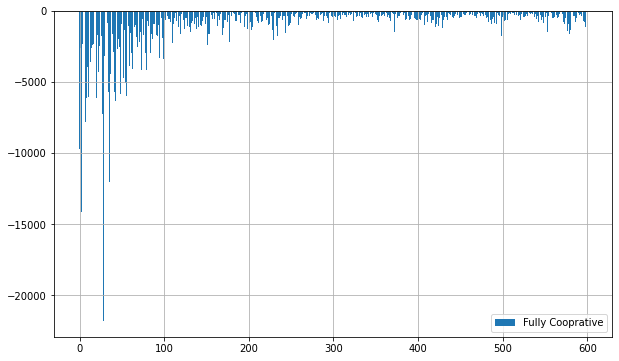

In [34]:
Q = np.zeros((7,10, 5, 5))

env = MultiWindyGridWorldEnv()
AgentA = FC_agent(numStates1 = 7, numStates2 = 10)
AgentB = FC_agent(numStates1 = 7, numStates2 = 10)


import copy
Q_prime = copy.deepcopy(Q)
n_episodes = 600
Reward_FC = []
for i_episode in range(1, n_episodes+1):

    stateA, stateB = env.reset()
    stateA = np.array(stateA)
    stateB = np.array(stateB)
    done = False
    done1, done2 = False, False
    R = 0
    Q_temp = copy.deepcopy(Q)
    while not done:
        if not done1:
            actionA = AgentA.chooseAction(stateA, 'A', done1, done2,Q)
        elif done1: 
            actionA = 4

        if not done2:
            actionB = AgentB.chooseAction(stateB, 'B', done1, done2,Q)
        elif done2: 
            actionB = 4

        next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)

        next_stateA = np.array(next_stateA)
        next_stateB = np.array(next_stateB)
        
        
        if actionB != 4:
            AgentB.updateQ(stateB, next_stateB, [np.random.randint(4), actionB], reward,Q)
        if actionA != 4: 
            AgentA.updateQ(stateA, next_stateA, [actionA, np.random.randint(4)], reward,Q)
            
        stateA = next_stateA
        stateB = next_stateB
        
        done = done1 and done2
        R += reward
    if Reward_FC:
      if R >= max(Reward_FC) :
        print(R)
        Q_prime = copy.deepcopy(Q_temp)
    
    Reward_FC.append(R)
    if AgentA.eps > 0.03:
            AgentA.eps *= 0.998889
    if AgentB.eps > 0.03:
            AgentB.eps *= 0.998889
            
    if AgentA.stationary_eps > 0.03:
            AgentA.stationary_eps *= 0.998889
    if AgentB.stationary_eps > 0.03:
            AgentB.stationary_eps *= 0.998889

    AgentA.alpha *= 0.9989
    AgentB.alpha *= 0.9989

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10, 6))

ax.bar(np.arange(len(Reward_FC)), Reward_FC, label ='Fully Cooprative')
ax.grid()
ax.legend()

In [41]:
stateA, stateB = env.reset()
stateA = np.array(stateA)
stateB = np.array(stateB)
done1, done2 = False, False
r = 0
while True: #epochs
    if done1 == False:
        actionA = AgentA.chooseAction(stateA, 'A', done1, done2,Q_prime)
    else: 
        actionA = 4

    if done2 == False:
        actionB = AgentB.chooseAction(stateB, 'B', done1, done2,Q_prime)
    else: 
        actionB = 4

    next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)

    next_stateA = np.array(next_stateA)
    next_stateB = np.array(next_stateB)

    stateA = next_stateA
    stateB = next_stateB

    r += reward

    done = done1 and done2
    
    clear_output(wait=True)
    env.render()
    sleep(0.1) 
    
    if done1 and done2:
      break

############
#          #
#          #
#          #
#       A  #
#          #
#          #
#          #
############



# Distributed Q-Lraning

In [3]:
class DQL_agent:
    def __init__(self, numStates1, numStates2, numActionsA=5, actions=None, eps=1, gamma=0.95):
        
        self.eps = eps
        self.gamma = gamma
        self.alpha = 0.8
        self. stationary_eps = eps
        self.pi = np.ones((numStates1,numStates2, numActionsA)) / numActionsA
        
        self.Q = np.zeros((numStates1,numStates2, numActionsA))
        self.numActionsA = numActionsA
        self.previous_action_id = None
        self.actions = actions
        
    def act(self,state, agent, doneA,doneB):

          action_id = self.chooseAction(state, agent, doneA,doneB)
          self.previous_action_id = action_id
          action = self.actions[action_id]
          self.previous_action = action
          return action
    
    def chooseAction(self, state, agent, doneA,doneB):
       if agent == 'A' and doneB and not doneA:
            action = self.select(state, self.stationary_eps)
            return action
        
       elif agent == 'B' and doneA and not doneB:
            action = self.select(state, self.stationary_eps)
            return action
       else:
            action = self.select(state, self.eps)
            return action
    
    def select(self, state, eps):
        if np.random.rand() < eps:
            action = np.random.randint(4)
            return action
        else:
            s1 = state[0]
            s2 = state[1]
            return np.unravel_index(np.argmax(self.Q[s1,s2]), self.Q[s1,s2].shape)[0]

    def learn(self, state, next_state, action, reward):
        Actions = np.arange(self.numActionsA)
        s1, s2 = state[0], state[1]
        ns1, ns2 = next_state[0], next_state[1]
        max_q = max([self.Q[ns1,ns2, action] for action in Actions])
        q = reward + self.gamma*max_q
        if q > self.Q[s1, s2, self.previous_action]:
            self.Q[s1, s2, self.previous_action] = q
        
        action_argmax_pi = 0
        max_pi_value = 0 
        for action in np.arange(self.numActionsA):
            if max_pi_value < self.pi[s1, s2, action]:
                action_argmax_pi = action
                max_pi_value  = self.pi[s1, s2, action]  
        
        max_q = max([self.Q[s1, s2, action] for action in Actions])
        if self.Q[s1, s2, action_argmax_pi] != max_q:
            actions_argmax_qs = [action for action in Actions if self.Q[s1, s2, action] == max_q]
            actions_argmax_q = np.random.choice(actions_argmax_qs)
            
            for a, _ in enumerate(self.pi[s1, s2]):
                if actions_argmax_q == a:
                    self.pi[s1, s2, a] = 1
                else:
                    self.pi[s1, s2, a] = 0

100


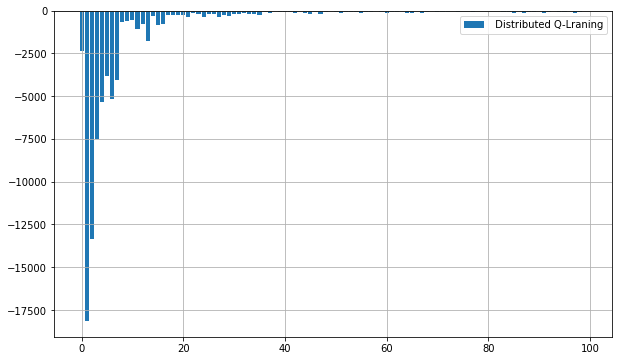

In [49]:
Actions = np.arange(5)

env = MultiWindyGridWorldEnv()
stateA, stateB = env.reset()
stateA = np.array(stateA)
stateB = np.array(stateB)

AgentA = DQL_agent(numStates1 = 7, numStates2 = 10, actions = Actions)
AgentB = DQL_agent(numStates1 = 7, numStates2 = 10, actions = Actions)

n_episodes = 100
Reward_DQL = []

for i_episode in range(1, n_episodes+1):
    R = 0
    stateA, stateB = env.reset()
    stateA = np.array(stateA)
    stateB = np.array(stateB)
    done = False
    done1, done2 = False, False
    while not done:
        if done1 == False:
            actionA = AgentA.act(stateA,'A',done1,done2)
        else: 
            actionA = 4
        
        if done2 == False:
            actionB = AgentB.act(stateB,'B',done1,done2)
        else: 
            actionB = 4
            
        next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)
        #reward += 10
        R += reward

        next_stateA = np.array(next_stateA)
        next_stateB = np.array(next_stateB)
        
        if actionB != 4:
            AgentB.learn(stateB, next_stateB, actionB, reward)
        if actionA != 4: 
            AgentA.learn(stateA, next_stateA, actionA, reward)
        stateA = next_stateA
        stateB = next_stateB
        
        done = done1 and done2

    if AgentA.eps > 0.05:
            AgentA.eps *= 0.99
    if AgentB.eps > 0.05:
            AgentB.eps *= 0.99
            
    if AgentA.stationary_eps > 0.05:
            AgentA.stationary_eps *= 0.99
    if AgentB.stationary_eps > 0.05:
            AgentB.stationary_eps *= 0.99

    AgentA.alpha *= 0.999
    AgentB.alpha *= 0.999

    if i_episode % 100 == 0:
      print(i_episode)

    Reward_DQL.append(R)

fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.bar(np.arange(len(Reward_DQL)), Reward_DQL, label =' Distributed Q-Lraning')
ax.grid()
ax.legend()

In [54]:
stateA, stateB = env.reset()
stateA = np.array(stateA)
stateB = np.array(stateB)
done1, done2 = False, False
r = 0
while True: #epochs
    if done1 == False:
        actionA = AgentA.chooseAction(stateA, 'A', done1, done2)
    else: 
        actionA = 4

    if done2 == False:
        actionB = AgentB.chooseAction(stateB, 'B', done1, done2)
    else: 
        actionB = 4

    next_stateA, next_stateB, reward, done1, done2 = env.step(actionA,actionB)
    r += reward
    next_stateA = np.array(next_stateA)
    next_stateB = np.array(next_stateB)

    stateA = next_stateA
    stateB = next_stateB

    done = done1 and done2
    
    clear_output(wait=True)
    env.render()
    sleep(0.1) 
    
    if done1 and done2:
        break


############
#          #
#          #
#          #
#       A  #
#          #
#          #
#          #
############

